# Implementing the DCGAN in PyTorch

The Generator is trying to generate images mimicking a given input dataset. 
While the Discriminator's job is to judge if the image you generated can be grouped with the input dataset or not.

##### Let's create a Generator classs

In [ ]:
from torch.nn import ConvTranspose2d
from torch.nn import BatchNorm2d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch import flatten
from torch import nn

class Generator(nn.Module):
    def __init__(self, inputDim=100, outputChannels=1):
        super(Generator, self).__init__()
        # first set of CONVT => RELU => BN
        self.ct1 = ConvTranspose2d(in_channels=inputDim,
            out_channels=128, kernel_size=4, stride=2, padding=0,
            bias=False)
        self.relu1 = ReLU()
        self.batchNorm1 = BatchNorm2d(128)
        # second set of CONVT => RELU => BN
        self.ct2 = ConvTranspose2d(in_channels=128, out_channels=64,
                    kernel_size=3, stride=2, padding=1, bias=False)
        self.relu2 = ReLU()
        self.batchNorm2 = BatchNorm2d(64)
        # last set of CONVT => RELU => BN
        self.ct3 = ConvTranspose2d(in_channels=64, out_channels=32,
                    kernel_size=4, stride=2, padding=1, bias=False)
        self.relu3 = ReLU()
        self.batchNorm3 = BatchNorm2d(32)
        # apply another upsample and transposed convolution, but
        # this time output the TANH activation
        self.ct4 = ConvTranspose2d(in_channels=32,
            out_channels=outputChannels, kernel_size=4, stride=2,
            padding=1, bias=False)
        self.tanh = Tanh()

    def forward(self, x):
        # pass the input through our first set of CONVT => RELU => BN
        # layers
        x = self.ct1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)
        # pass the output from previous layer through our second
        # CONVT => RELU => BN layer set
        x = self.ct2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)
        # pass the output from previous layer through our last set
        # of CONVT => RELU => BN layers
        x = self.ct3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        # pass the output from previous layer through CONVT2D => TANH
        # layers to get our output
        x = self.ct4(x)
        output = self.tanh(x)
        return output

##### Below is the Discriminator class

In [ ]:
class Discriminator(nn.Module):
	def __init__(self, depth, alpha=0.2):
		super(Discriminator, self).__init__()
		# first set of CONV => RELU layers
		self.conv1 = Conv2d(in_channels=depth, out_channels=32,
				kernel_size=4, stride=2, padding=1)
		self.leakyRelu1 = LeakyReLU(alpha, inplace=True)
		# second set of CONV => RELU layers
		self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=4,
				stride=2, padding=1)
		self.leakyRelu2 = LeakyReLU(alpha, inplace=True)
		# first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=3136, out_features=512)
		self.leakyRelu3 = LeakyReLU(alpha, inplace=True)
		# sigmoid layer outputting a single value
		self.fc2 = Linear(in_features=512, out_features=1)
		self.sigmoid = Sigmoid()
		
	def forward(self, x):
		# pass the input through first set of CONV => RELU layers
		x = self.conv1(x)
		x = self.leakyRelu1(x)
		# pass the output from the previous layer through our second
		# set of CONV => RELU layers
		x = self.conv2(x)
		x = self.leakyRelu2(x)
		# flatten the output from the previous layer and pass it
		# through our first (and only) set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.leakyRelu3(x)
		# pass the output from the previous layer through our sigmoid
		# layer outputting a single value
		x = self.fc2(x)
		output = self.sigmoid(x)
		return output

Training The DCGAN

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from sklearn.utils import shuffle
from imutils import build_montages
from torch.optim import Adam
from torch.nn import BCELoss
from torch import nn
import numpy as np
import argparse
import torch
import cv2
import os

# custom weights initialization called on generator and discriminator
def weights_init(model):
	classname = model.__class__.__name__
	# check if the classname contains the word "conv"
	if classname.find("Conv") != -1:
		# intialize the weights from normal distribution
		nn.init.normal_(model.weight.data, 0.0, 0.02)
	# otherwise, check if the name contains the word "BatcnNorm"
	elif classname.find("BatchNorm") != -1:
		# intialize the weights from normal distribution and set the
		# bias to 0
		nn.init.normal_(model.weight.data, 1.0, 0.02)
		nn.init.constant_(model.bias.data, 0)

In [4]:
NUM_EPOCHS = 20
BATCH_SIZE = 128

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataTransforms = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5), (0.5))]
)

# load the MNIST dataset and stack the training and testing data
# points so we have additional training data
print("[INFO] loading MNIST dataset...")
trainData = MNIST(root="data", train=True, download=True,
	transform=dataTransforms)
testData = MNIST(root="data", train=False, download=True,
	transform=dataTransforms)
data = torch.utils.data.ConcatDataset((trainData, testData))

dataloader = DataLoader(data, shuffle=True,
	batch_size=BATCH_SIZE)

[INFO] loading MNIST dataset...
Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:14<00:00, 698371.00it/s] 


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 252140.68it/s]


Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1571698.48it/s]


Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1751772.76it/s]


Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw



In [27]:
len(data)

70000

In [6]:
stepsPerEpoch = len(dataloader.dataset) // BATCH_SIZE

print("[INFO] building generator...")
gen = Generator(inputDim=100, outputChannels=1)
gen.apply(weights_init)
gen.to(DEVICE)

print("[INFO] building discriminator...")
disc = Discriminator(depth=1)
disc.apply(weights_init)
disc.to(DEVICE)

# initialize optimizer for both generator and discriminator
genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999),
	weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999),
	weight_decay=0.0002 / NUM_EPOCHS)

criterion = BCELoss()

[INFO] building generator...
[INFO] building discriminator...


In [7]:
print("[INFO] starting training...")
benchmarkNoise = torch.randn(256, 100, 1, 1, device=DEVICE)

realLabel = 1
fakeLabel = 0

for epoch in range(NUM_EPOCHS):
	print("[INFO] starting epoch {} of {}...".format(epoch + 1,
		NUM_EPOCHS))
	
	epochLossG = 0
	epochLossD = 0
	for x in dataloader:
		disc.zero_grad()
		
		images = x[0]
		images = images.to(DEVICE)
		
		bs =  images.size(0)
		labels = torch.full((bs,), realLabel, dtype=torch.float,
			device=DEVICE)
		
		output = disc(images).view(-1)
		# calculate the loss on all-real batch
		errorReal = criterion(output, labels)
		errorReal.backward()

		noise = torch.randn(bs, 100, 1, 1, device=DEVICE)
		# generate a fake image batch using the generator
		fake = gen(noise)
		labels.fill_(fakeLabel)

		# perform a forward pass through discriminator using fake
		# batch data
		output = disc(fake.detach()).view(-1)
		errorFake = criterion(output, labels)
		errorFake.backward()
		errorD = errorReal + errorFake
		discOpt.step()

		gen.zero_grad()
		# update the labels as fake labels are real for the generator
		# and perform a forward pass  of fake data batch through the
		# discriminator
		labels.fill_(realLabel)
		output = disc(fake).view(-1)
		# calculate generator's loss based on output from
		# discriminator and calculate gradients for generator
		errorG = criterion(output, labels)
		errorG.backward()
		# update the generator
		genOpt.step()
		# add the current iteration loss of discriminator and
		# generator
		epochLossD += errorD
		epochLossG += errorG

	print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(
		epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))
	
	if (epoch + 1) % 2 == 0:
		# set the generator in evaluation phase, make predictions on
		# the benchmark noise, scale it back to the range [0, 255],
		# and generate the montage
		gen.eval()
		images = gen(benchmarkNoise)
		images = images.detach().cpu().numpy().transpose((0, 2, 3, 1))
		images = ((images * 127.5) + 127.5).astype("uint8")
		images = np.repeat(images, 3, axis=-1)
		vis = build_montages(images, (28, 28), (16, 16))[0]
		
		# save output
		p = os.path.join('output', "epoch_{}.png".format(
			str(epoch + 1).zfill(4)))
		cv2.imwrite(p, vis)
		gen.train()

[INFO] starting training...
[INFO] starting epoch 1 of 20...
[INFO] Generator Loss: 4.1125, Discriminator Loss: 0.5142
[INFO] starting epoch 2 of 20...
[INFO] Generator Loss: 1.0148, Discriminator Loss: 1.1440
[INFO] starting epoch 3 of 20...
[INFO] Generator Loss: 0.8686, Discriminator Loss: 1.2543
[INFO] starting epoch 4 of 20...
[INFO] Generator Loss: 0.8309, Discriminator Loss: 1.2938
[INFO] starting epoch 5 of 20...
[INFO] Generator Loss: 0.8241, Discriminator Loss: 1.3051
[INFO] starting epoch 6 of 20...
[INFO] Generator Loss: 0.8059, Discriminator Loss: 1.3045
[INFO] starting epoch 7 of 20...
[INFO] Generator Loss: 0.8055, Discriminator Loss: 1.3038
[INFO] starting epoch 8 of 20...
[INFO] Generator Loss: 0.8181, Discriminator Loss: 1.3003
[INFO] starting epoch 9 of 20...
[INFO] Generator Loss: 0.8291, Discriminator Loss: 1.2916
[INFO] starting epoch 10 of 20...
[INFO] Generator Loss: 0.8447, Discriminator Loss: 1.2856
[INFO] starting epoch 11 of 20...
[INFO] Generator Loss: 0.84

Let's see an example of what ot generates:

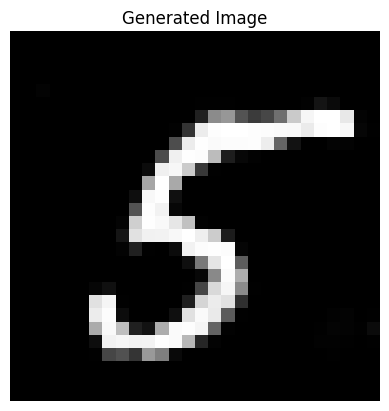

torch.Size([28, 28])


In [24]:
import matplotlib.pyplot as plt
import numpy as np
gen.eval()

noise = torch.randn(bs, 100, 1, 1, device=DEVICE)
img = gen(noise).detach().cpu()

img = img[0][0]
img = (img + 1.0) / 2.0
img = np.clip(img, 0, 1)

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title("Generated Image")
plt.show()
print(img.shape)  